In [14]:
# install.packages("rstan", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
# install.packages(c("bayesrules", "tidyverse", "janitor", "rstanarm", "bayesplot", "tidybayes", "broom.mixed", "modelr", "e1071", "forcats"),  dependencies = TRUE)

In [15]:
library(bayesrules)
library(tidyverse)
library(janitor)

오해의 소지가 있는, 편향된 뉴스가 온라인 뉴스 및 소셜 미디어 플랫폼과 함께 확산되어 사용자가 품질 관리가 거의 없이 기사를 게시되며, 이에 따라서 독자가 기사를 "진짜" 또는 "가짜"로 표시하도록 돕는 것이 점점 더 중요해지고 있음

<br>

#### 특정 컬렉션에 있는 기사의 40%가 가짜이고 60%가 진짜

In [11]:
data(fake_news)

In [13]:
fake_news %>% 
  tabyl(type) %>% 
  adorn_totals("row")

,type,n,percent
,<fct>,<int>,<dbl>
1,fake,60,0.4
2,real,90,0.6
3,Total,150,1.0



- **위의 비율은 실제 뉴스와 가짜 뉴스의 일반적인 특징 이 아닌 전반적인 비율만 고려.** 

    - 예를 들어, 기사 제목이 "대통령에게는 재미있는 비밀이 있습니다!"라고 한다면,
    
        **실제 뉴스 기사에서는 느낌표를 사용하는 것이 이상한 선택처럼 보일 수 있으며, 이는 우리의 본능에 근거.** 
        
        **기사 컬렉션에서 가짜 뉴스 제목의 26.67%(60개 중 16개)가 느낌표를 사용하며, 실제 뉴스 제목 중 2.22%(90개 중 2개)만이 느낌표를 사용.**

<br>

#### 모순되는 두 가지 정보
1. 우리의 사전 정보에 따르면 대부분의 기사는 진짜일 가능성이 높음
2. 그러나 느낌표를 포함한 기사는 가짜 뉴스일 가능성이 더 높음 

<br>

**기사가 가짜인지 여부에 대한 베이지안 지식 구축 다이어그램**

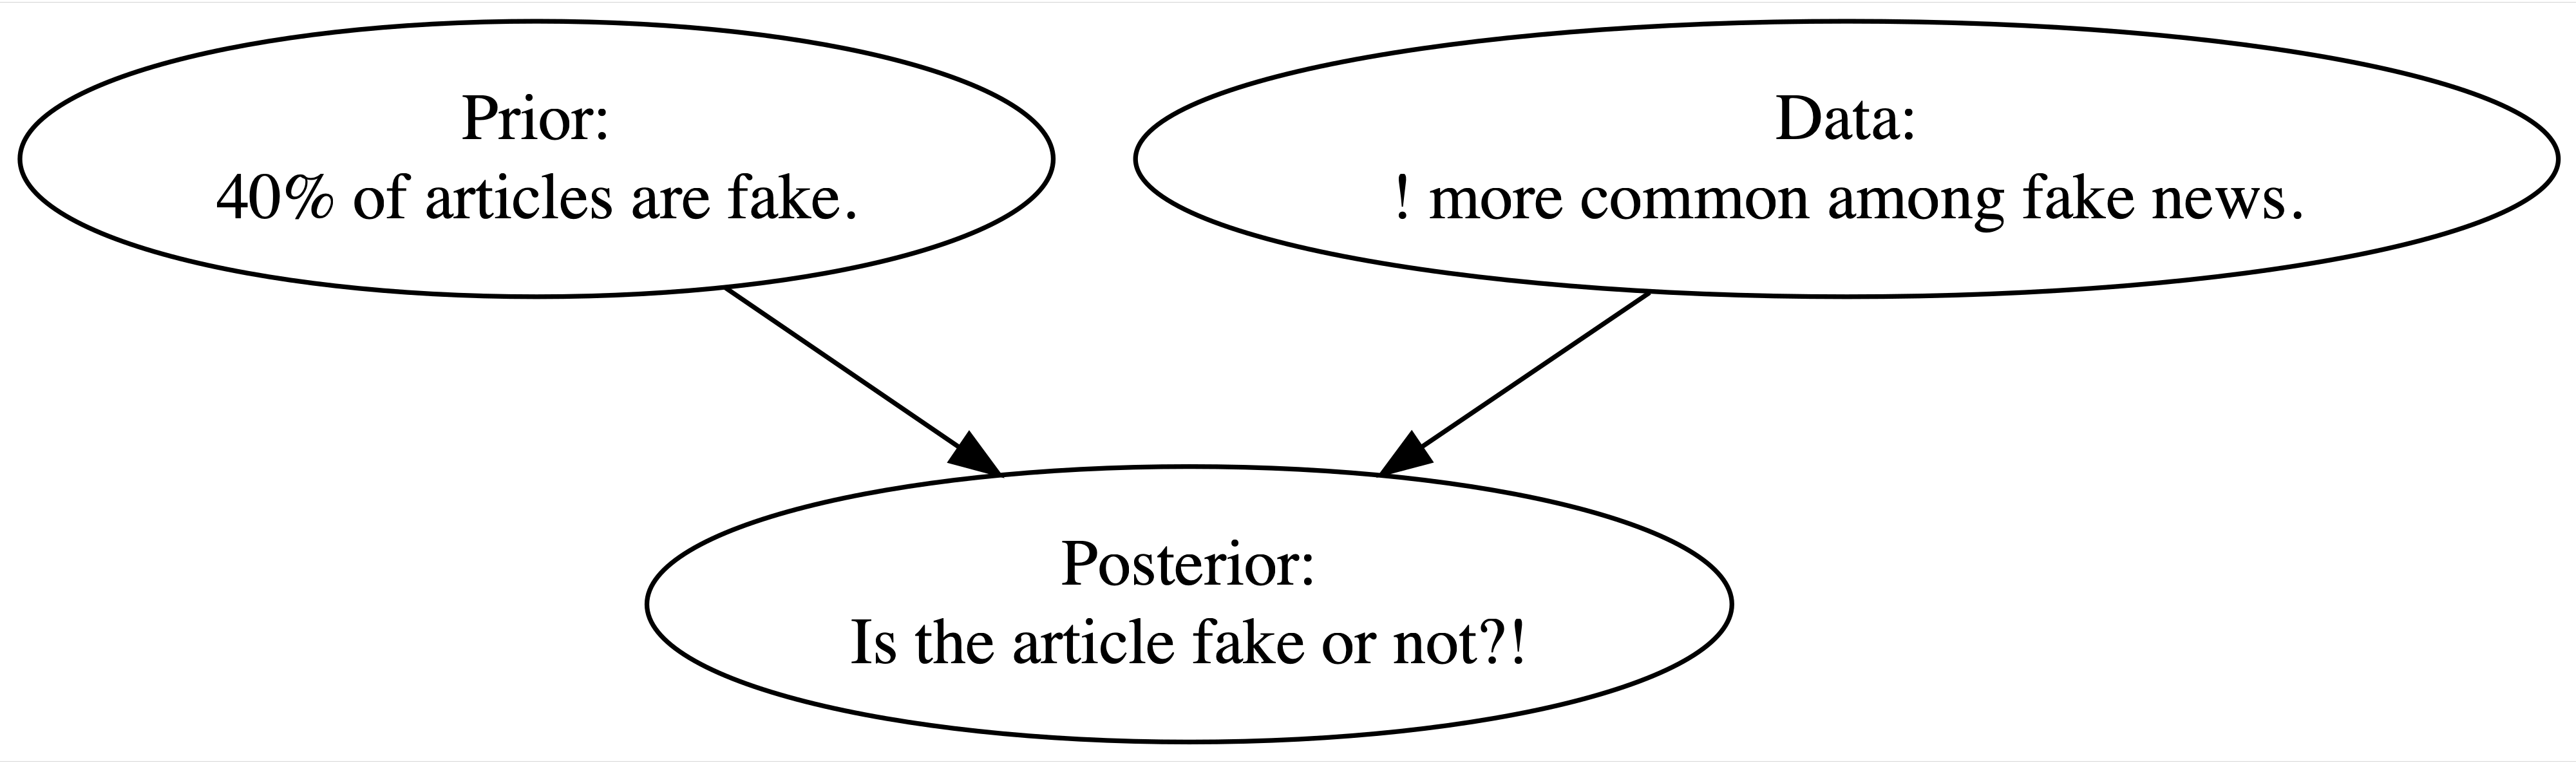

<br>

## 02.01. 베이지안 모델 구축

<br>

### 사전확률
- 베이지안 분석의 첫 번째 단계로 새 기사가 가짜인지 여부에 대한 사전 이해를 공식화
- 데이터를 기반으로 우리는 기사의 40%가 가짜이고 60%가 진짜라는 것을 확인.

    즉, 새 기사를 읽기도 전에 그것이 가짜일 사전 확률은 0.4이고, 그렇지 않을 확률은 0.6
    
$$P(B) = 0.4\;\;P(B^c)=0.6$$

<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>
<span id="tab:fakeprior"></span>가짜 뉴스에 대한 사전모델
</caption>
<thead>
<tr>
<th style="text-align:left;">
event
</th>
<th style="text-align:center;">
<span class="math inline">\(B\)</span>
</th>
<th style="text-align:center;">
<span class="math inline">\(B^c\)</span>
</th>
<th style="text-align:center;">
Total
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;">
probability
</td>
<td style="text-align:center;">
$0.4$
</td>
<td style="text-align:center;">
$0.6$
</td>
<td style="text-align:center;">
$1$
</td>
</tr>
</tbody>
</table>

<br>

## 02.02. 조건부 확률 & 가능도
- 베이지안 분석의 두 번째 단계에서는 새 기사에서 수집한 데이터의 통찰력을 요약
- 느낌표 데이터가 실제 뉴스보다 가짜 뉴스와 더 잘 호환된다는 관찰을 공식화

    **기사가 가짜인 경우 제목에 느낌표가 사용될 확률은 대략 26.67%**
    
    **기사가 진짜인 경우 느낌표 를 사용할 확률은 대략 2.22%에 불과**
    
    **느낌표의 발생 여부는 기사가 가짜인지 여부에 따라 달라지거나 조건이 따른다 는 것이 분명** $\rightarrow$ 이는 느낌표 사용에 대한 다음과 같은 조건부 확률

$$P(A | B) = 0.2667 \;\; \text{ and } \;\; P(A | B^c) = 0.0222.$$

<br>

<hr>

### 조건부 확률, 비조건부 확률

> $P(A)$는 $B$에 대한 정보없이 $A$를 관측할 확률
>
> $P(A|B)$는 $B$에 대한 정보를 통하여 비추어본 $A$의 관측 확률


- $P(A|B)$와 $P(A)$의 비교를 통하여, $A$에 대한 $B$의 영향력을 알 수 있음

<br>

<hr>

### 독립 사건

> **$B$의 발생이 $A$의 발생에 어떠한 정보도 말해주지 않는다면, 두 사건 $A$와 $B$는 독립**
>
> $P(A|B) = P(A)  .$

<br>

<hr>

### 가능도

#### 확률 vs 가능도
> $B$를 알고 있을때, 조건부확률 $P(\cdot|B)$를 통하여 알려지지 않은 사건 $B$가 발생할 때의 $A$와 $A^c$의 확률을 비교할 수 있음
>
> $P(A|B) \; \text{ vs } \; P(A^c|B).$
>
> $A$를 알고 있을때, 가능도함수 $L( \cdot | A) = P(A | \cdot)$는 $A$와 $B$, $B^c$의 상대적 호환성을 평가할 수 있음.
>
> $L(B|A) \; \text{ vs } \; L(B^c|A).$




<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>
<span id="tab:fakelike"> </span>가짜뉴스에 대한 사전확률과 가능도
</caption>
<thead>
<tr>
<th style="text-align:left;">
event
</th>
<th style="text-align:left;">
<span class="math inline">\(B\)</span>
</th>
<th style="text-align:left;">
<span class="math inline">\(B^c\)</span>
</th>
<th style="text-align:left;">
Total
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;">
prior probability
</td>
<td style="text-align:left;">
0.4
</td>
<td style="text-align:left;">
0.6
</td>
<td style="text-align:left;">
1
</td>
</tr>
<tr>
<td style="text-align:left;">
likelihood
</td>
<td style="text-align:left;">
0.2667
</td>
<td style="text-align:left;">
0.0222
</td>
<td style="text-align:left;">
0.2889
</td>
</tr>
</tbody>
</table>

- 사전 확률의 합은 1이 되지만 가능도의 합은 그렇지 않음
- 사전확률에서는 기사가 실제일 가능성이 가장 높다고 하였지만 $P(B) < P(B^c)$

    느낌표를 가지고 있는 기사들의 정보를 고려한다면 $L(B|A) > L(B^c|A)$, 느낌표를 가지고 있는 기사는 가짜 뉴스일 근거가 됨

<br>

<hr>

### 정규화 상수
#### 결합확률과 주변확률 계산


#### 총확률의 법칙 (Law of Total Probability, LTP)
- **$A$와 $B$의 결합확률**

    $P(A \cap B) = P(A|B)P(B) = 0.2667 \cdot 0.4 = 0.1067.$

    **기사가 가짜인데, 기사에 느낌표가 포함되지 않을 확률** 
  
    $P(A^c|B) = 1 - P(A|B) = 1 - 0.2667 = 0.7333.$
    
    **따라서**
    
    $P(A^c \cap B) = P(A^c|B)P(B) = 0.7333 \cdot 0.4 = 0.2933  .$
    
    **이며, $B$의 총 확률은**

    $P(B) = P(A \cap B) + P(A^c \cap B) = 0.1067 + 0.2933 = 0.4 .$

- **$A$도 마찬가지로**

    $\begin{split}
    P(A \cap B^c)   & = P(A|B^c)P(B^c) = 0.0222 \cdot 0.6 = 0.0133 \\
    P(A^c \cap B^c) & = P(A^c|B^c)P(B^c) = 0.9778 \cdot 0.6 = 0.5867.\\
    \end{split}$
    
    **따라서, $A$의 총 확률은**

    $P(A) = P(B^c) = P(A \cap B^c) + P(A^c \cap B^c) = 0.0133 + 0.5867 = 0.6 .$
    

<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>
<span id="tab:jointfake">T</span>A joint probability model of the fake status and exclamation point usage across all articles.
</caption>
<thead>
<tr>
<th style="text-align:left;">
</th>
<th style="text-align:right;">
<span class="math inline">\(B\)</span>
</th>
<th style="text-align:right;">
<span class="math inline">\(B^c\)</span>
</th>
<th style="text-align:center;">
Total
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;">
<span class="math inline">\(A\)</span>
</td>
<td style="text-align:right;">
0.1067
</td>
<td style="text-align:right;">
0.0133
</td>
<td style="text-align:center;">
0.12
</td>
</tr>
<tr>
<td style="text-align:left;">
<span class="math inline">\(A^c\)</span>
</td>
<td style="text-align:right;">
0.2933
</td>
<td style="text-align:right;">
0.5867
</td>
<td style="text-align:center;">
0.88
</td>
</tr>
<tr>
<td style="text-align:left;">
Total
</td>
<td style="text-align:right;">
0.4
</td>
<td style="text-align:right;">
0.6
</td>
<td style="text-align:center;">
1
</td>
</tr>
</tbody>
</table>

> $A$와 $B$ 사건의 결합 확률 $A \cap B$는, $B$가 주여졌을 떄의 $A$의 조건부 확률과 $B$의 주변확률을 통하여 계산
>
> $\begin{equation}
P(A \cap B) = P(A | B)P(B).
\end{equation}$
>
> 만약, $A$와 $B$가 독립이라면, $P(A \cap B) = P(A)P(B).$
> 
> $P(B)$가 0이 아니라는 가정하에, 양 변을 $P(B)$로 나누면, 이는 $B$가 주어졌을 때의 $A$의 조건부확률
> 
> $\begin{equation}
P(A | B) = \frac{P(A \cap B)}{P(B)}.
\end{equation}$


- **위의 정리에 따라 $A$는 아래와 같음**

    $\begin{equation}
\begin{split}
P(A) & = P(A \cap B) + P(A \cap B^c) = P(A|B)P(B) + P(A|B^c)P(B^c)  .
\end{split}
\end{equation}$

<br>

<hr>

### 사후확률

> $L(B|A) = P(A|B)$와 $L(B^c|A) = P(A|B^c)$ 등식에 따라서
>
> $A$를 관측했을 때, 
> 
> $\begin{equation} 
  P(B |A) = \frac{P(A \cap B)}{P(A)} = \frac{P(B)L(B|A)}{P(A)}
\end{equation}$이며, 
>
> $A$의 총확률은 $\begin{equation}
P(A) = P(B)L(B|A) + P(B^c)L(B^c|A)
\end{equation}$이다.
> 

$$\text{posterior} = \frac{\text{prior } \cdot \text{ likelihood}}{\text{normalizing constant}}  .$$

<br>

#### 위의 정리에 따라서, 기사가 느낌표를 포함한다면, 기사가 가짜뉴스인지에 대한 사후확률은

$$P(B|A) = \frac{P(B)L(B|A)}{P(A)} = \frac{ 0.4 \cdot 0.2667}{0.12} = 0.889 .$$

<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>
<span id="tab:fakeposterior"> </span>가짜뉴스 여부에 대한 사전확률 & 사후확률
</caption>
<thead>
<tr>
<th style="text-align:left;">
event
</th>
<th style="text-align:left;">
<span class="math inline">\(B\)</span>
</th>
<th style="text-align:left;">
<span class="math inline">\(B^c\)</span>
</th>
<th style="text-align:left;">
Total
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;">
prior probability
</td>
<td style="text-align:left;">
0.4
</td>
<td style="text-align:left;">
0.6
</td>
<td style="text-align:left;">
1
</td>
</tr>
<tr>
<td style="text-align:left;">
posterior probability
</td>
<td style="text-align:left;">
0.889
</td>
<td style="text-align:left;">
0.111
</td>
<td style="text-align:left;">
1
</td>
</tr>
</tbody>
</table>

<br>

## 02.03. 시뮬레이션

- 사전확률 정의

In [18]:
article <- data.frame(type = c("real", "fake"))

prior <- c(0.6, 0.4)

- 사전확률 하에서 10,000개의 기사표본 추출

In [25]:
set.seed(84735)
article_sim <- sample_n(article, size = 10000, weight = prior, replace = TRUE)
article_sim %>% head

,type
,<chr>
1,fake
2,fake
3,real
4,fake
5,fake
6,real


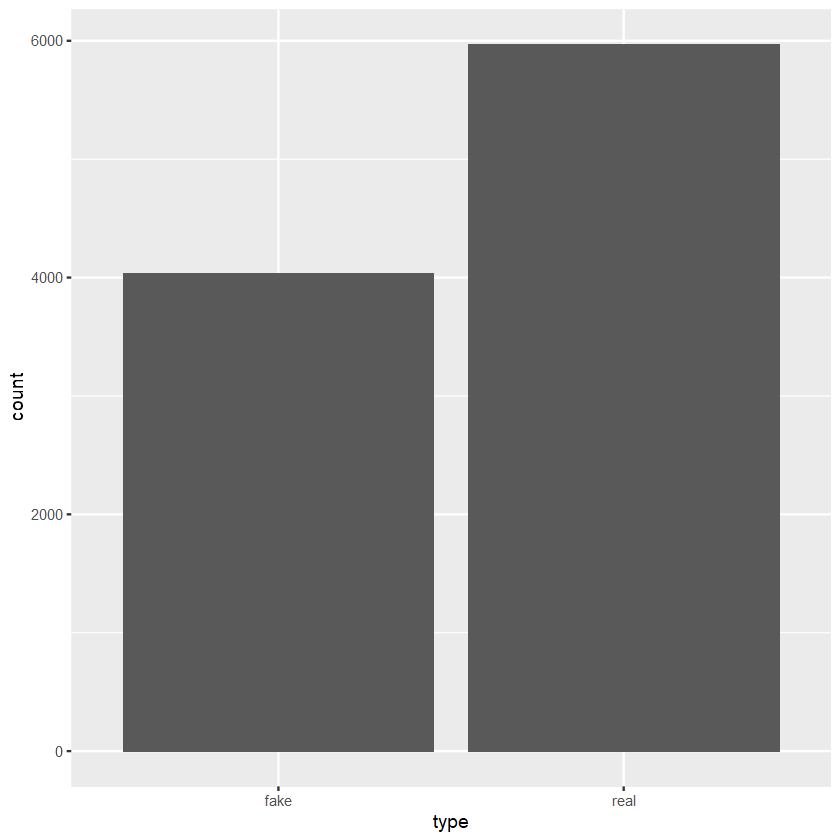

In [26]:
ggplot(article_sim, aes(x = type)) + 
  geom_bar()

In [27]:
article_sim %>% 
  tabyl(type) %>% 
  adorn_totals("row")

,type,n,percent
,<chr>,<int>,<dbl>
1,fake,4031,0.4031
2,real,5969,0.5969
3,Total,10000,1.0000


<br>

- 각 관측값마다, 진짜/가짜 뉴스 여부에 따라 느낌표가 포함될 확률 계산

In [29]:
article_sim <- article_sim %>% 
  mutate(data_model = case_when(type == "fake" ~ 0.2667, type == "real" ~ 0.0222))

article_sim %>% head

,type,data_model
,<chr>,<dbl>
1,fake,0.2667
2,fake,0.2667
3,real,0.0222
4,fake,0.2667
5,fake,0.2667
6,real,0.0222


<br>

- 각 관측값 마다 느낌표가 포함될 확률을 적용하여, 느낌표가 포함 여부에 대하여 시뮬레이션

In [30]:
data <- c("no", "yes")

In [31]:
set.seed(3)
article_sim <- article_sim %>%
  group_by(1:n()) %>% 
  mutate(usage = sample(data, size = 1, prob = c(1 - data_model, data_model)))

In [32]:
article_sim %>% head

type,data_model,1:n(),usage
<chr>,<dbl>,<int>,<chr>
fake,0.2667,1,no
fake,0.2667,2,yes
real,0.0222,3,no
fake,0.2667,4,no
fake,0.2667,5,no
real,0.0222,6,no


- 시뮬레이션 결과

In [33]:
article_sim %>% 
  tabyl(usage, type) %>% 
  adorn_totals(c("col","row"))

,usage,fake,real,Total
,<chr>,<dbl>,<dbl>,<dbl>
1,no,2961,5833,8794
2,yes,1070,136,1206
3,Total,4031,5969,10000


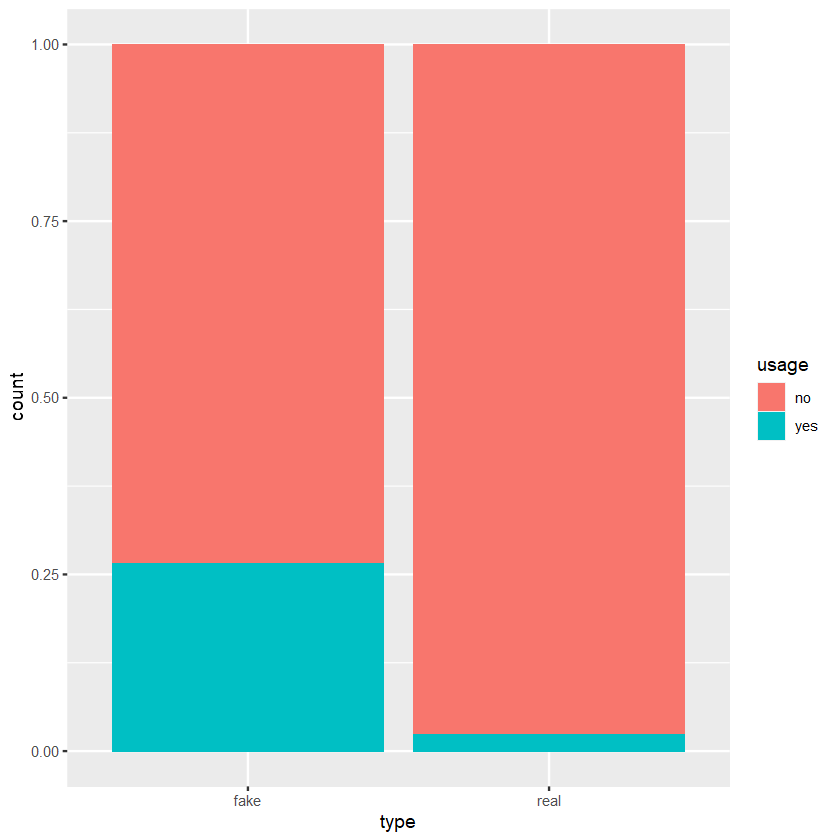

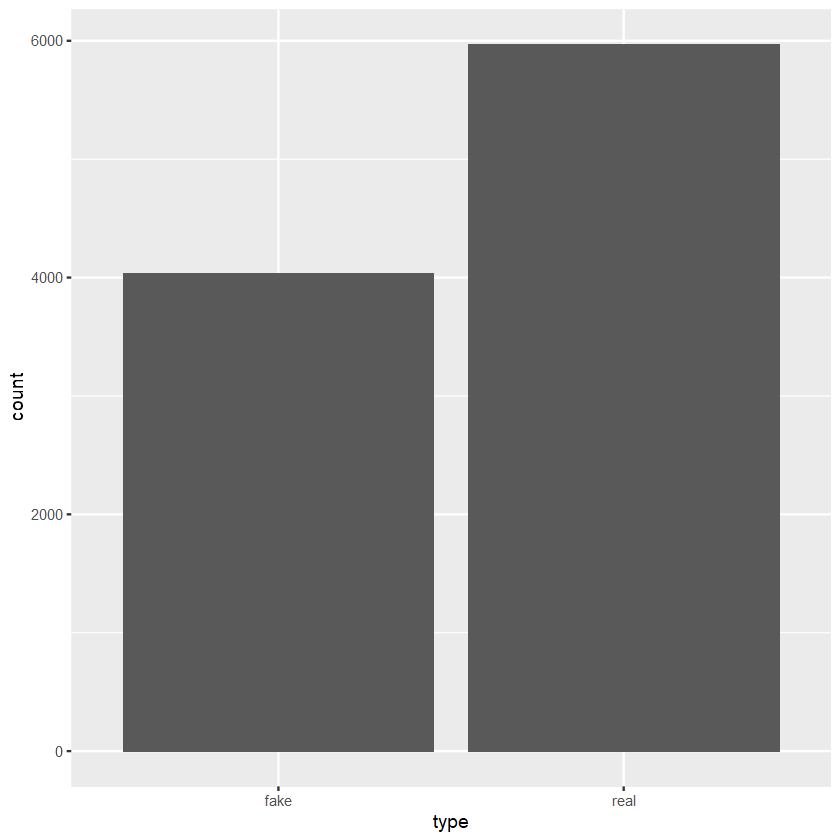

In [34]:
ggplot(article_sim, aes(x = type, fill = usage)) + 
  geom_bar(position = "fill")

ggplot(article_sim, aes(x = type)) + 
  geom_bar()

- 사후확률 계산

    느낌표를 사용한 1070개의 시뮬레이션 기사 중 대략적으로 88.7%는 가짜뉴스
    
    이 근사치는 실제 사후 확률인 0.889에 매우 가까움

In [35]:
article_sim %>% 
  filter(usage == "yes") %>% 
  tabyl(type) %>% 
  adorn_totals("row")

,type,n,percent
,<chr>,<int>,<dbl>
1,fake,1070,0.8872305
2,real,136,0.1127695
3,Total,1206,1.0000000


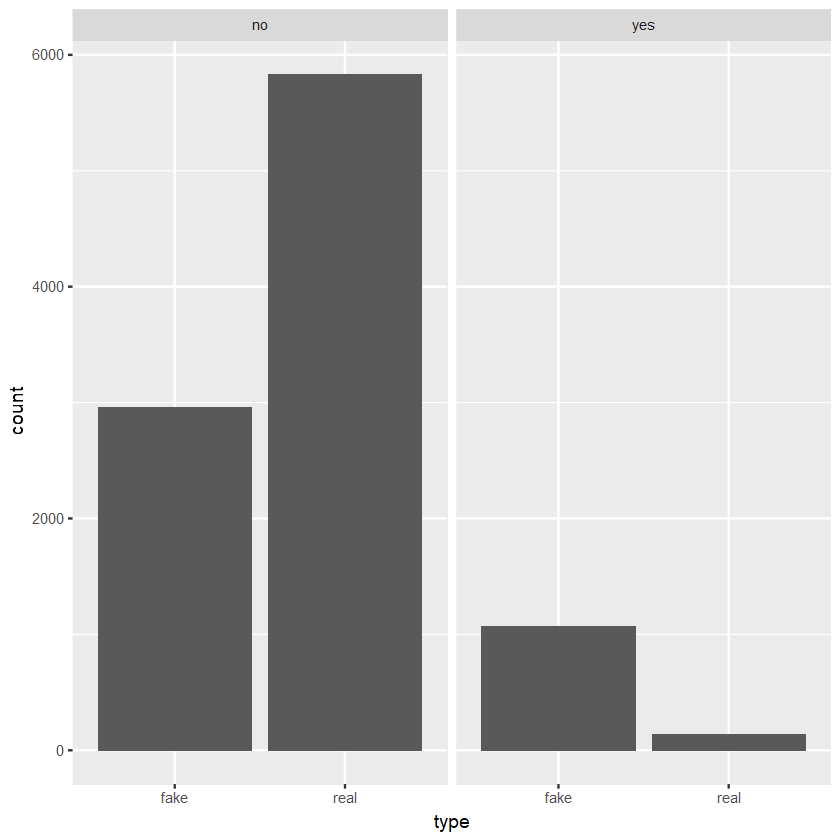

In [36]:
ggplot(article_sim, aes(x = type)) + 
  geom_bar() + 
  facet_wrap(~ usage)

<br>

## 02.04. 팝 vs 탄산음료 vs 콜라

- 한 사람에 대해 아무것도 모르는 상태에서, 미국 인구 조사 수치는 거주지역에 대한 사전 정보를 제공

<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>
<span id="tab:poppost"> </span>미국 지역별 인구에 따른 사전/사후 확률
</caption>
<thead>
<tr>
<th style="text-align:left;">
region
</th>
<th style="text-align:center;">
M
</th>
<th style="text-align:center;">
N
</th>
<th style="text-align:center;">
S
</th>
<th style="text-align:center;">
W
</th>
<th style="text-align:center;">
Total
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;">
probability
</td>
<td style="text-align:center;">
0.21
</td>
<td style="text-align:center;">
0.17
</td>
<td style="text-align:center;">
0.38
</td>
<td style="text-align:center;">
0.24
</td>
<td style="text-align:center;">
1
</td>
</tr>
</tbody>
</table>

- 탄산음료에 대한 사랑으로 전국적으로 통일되어 있지만, '팝', '소다', '코카콜라' 등의 공통 지역 용어를 사용하여 부르는 명칭에 따라 분열되어 있음. 따라서 한 사람이 탄산 콜라 음료를 가리키며 “내 '팝'좀 건네주세요”라고 말하는 것을 본다면, 그 사람의 거주지를 유추 가능

In [37]:
data(pop_vs_soda)

<br>

- 각 지역별 탄산음료를 '팝'이라고 부르는 사람의 비율

$$L(M|A) = 0.6447, \;\;\;\; L(N|A) = 0.2734, \;\;\;\; L(S|A) = 0.0792, \;\;\;\; L(W|A) = 0.2943$$

$$(L(M|A) > L(W|A) > L(N|A) > L(S|A))$$

In [38]:
pop_vs_soda %>% 
  tabyl(pop, region) %>% 
  adorn_percentages("col")

pop,midwest,northeast,south,west
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,0.3552958,0.7266026,0.92077769,0.7057215
TRUE,0.6447042,0.2733974,0.07922231,0.2942785


<br>

#### 한 사람이 탄산음료를 "팝"이라고 부른다면, 그 사람이 남부에 거주할 사후 확률
$$\begin{equation}
P(S | A) =  \frac{P(S)L(S|A)}{P(A)}  =\frac{0.38 \cdot 0.0792}{0.2826}\; \approx 0.1065  .
\end{equation}$$

<br>

#### 또한, 총확률의 법칙을 이용하여

$$\begin{split}
P(A) & = L(M|A)P(M) + L(N|A)P(N) + L(S|A)P(S) + L(W|A)P(W) \\
     & = 0.6447 \cdot 0.21 + 0.2734 \cdot 0.17 + 0.0792 \cdot 0.38 + 0.2943 \cdot 0.24\\
     & \approx 0.2826  . \\
\end{split}$$

<br>

<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>
<span id="tab:poppost"></span>한 사람이 탄산음료를 '팝'이라고 부를 때, 그 사람의 거주지에 대한 사후확률
</caption>
<thead>
<tr>
<th style="text-align:left;">
region
</th>
<th style="text-align:left;">
M
</th>
<th style="text-align:left;">
N
</th>
<th style="text-align:left;">
S
</th>
<th style="text-align:left;">
W
</th>
<th style="text-align:left;">
Total
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;">
prior probability
</td>
<td style="text-align:left;">
0.21
</td>
<td style="text-align:left;">
0.17
</td>
<td style="text-align:left;">
0.38
</td>
<td style="text-align:left;">
0.24
</td>
<td style="text-align:left;">
1
</td>
</tr>
<tr>
<td style="text-align:left;">
posterior probability
</td>
<td style="text-align:left;">
0.4791
</td>
<td style="text-align:left;">
0.1645
</td>
<td style="text-align:left;">
0.1065
</td>
<td style="text-align:left;">
0.2499
</td>
<td style="text-align:left;">
1
</td>
</tr>
</tbody>
</table>

<br>

## 02.05. 확률변수에 대한 베이지안 모델

<br>

### 사전확률

> 1996년, 세계 체스 챔피언 게리 카스파로프는, IBM 슈퍼컴퓨터 딥 블루와 매우 기대되는 여섯 게임의 체스 경기를 진행
>
> 여섯 게임 중에서, 카스파로프는 세 게임을 이기고, 두 게임을 비기고, 한 게임을 패배

<br>

#### $π$ : 카스파로프가 재대결에서 승리할 확률이면서, 딥 블루의 능력에 대한 척도 
**$\rightarrow$ 알려지지 않았고, 시간에 따라 변화하거나 변동할 수 있는 확률변수**



<br>

#### **카스파로프가 딥 블루에게 승리할 확률$\pi$에 대한 사전분포의 확률질량함수 (PMF)**
<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>
<span id="tab:chessprior"></span> <span class="math inline"></span>
</caption>
<thead>
<tr>
<th style="text-align:left;">
<span class="math inline">\(\pi\)</span>
</th>
<th style="text-align:center;">
0.2
</th>
<th style="text-align:center;">
0.5
</th>
<th style="text-align:center;">
0.8
</th>
<th style="text-align:center;">
Total
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;">
<span class="math inline">\(f(\pi)\)</span>
</td>
<td style="text-align:center;">
0.10
</td>
<td style="text-align:center;">
0.25
</td>
<td style="text-align:center;">
0.65
</td>
<td style="text-align:center;">
1
</td>
</tr>
</tbody>
</table>

<br>

#### 이산형 확률모형
> $Y$가 이산형 확률변수일때, $Y$의 확률모형은 확률질량함수 (PMF) $f(y)$을 가지고 있으며
> 
> $f(y) = P(Y = y)$로 정의되며, 아래와 같은 속성을 가지고 있음
> 
> 1. 모든 $y$에 대하여 $0 \le f(y) \le 1$
>
> 2. $\sum_{\text{all } y} f(y) = 1$

<br>

### 이항분포
- $Y$는 6경기에서 카스파로프가 승리한 횟수이며, $\{0,1,...,6\}$의 범위를 가짐

    **또한 $Y$는 카스파로프의 승리확률 $\pi$에 따라 변동되는 확률변수**
    
    - $\pi$가 높다면 $Y$는 증가하며, $\pi$가 낮아지면 $Y$는 감소
    
    <br>
    
    *$\rightarrow$ 이러한 의존성에 의하여, $Y$는 $\pi$에 대한 조건부 확률 모델로 정의됨**
    
<br>

<hr>

#### $Y$에 대한 조건부 확률 모델
> $Y$가 $\pi$에 의존하는 이산형 확률변수일 때, 
>
> $\pi$값에 대한 $Y$의 조건부 확률 모델은, 조건부 확률 질량 함수 (Pmf) $f(y|\pi)$를 가지며
>
> $$f(y|\pi) = P(Y = y | \pi)$$
>
> 다음과 같은 속성을 가짐
>
> 1. 모든 $y$에 대하여, $0 \le f(y|\pi) \le 1$
>
>2.  $\sum_{\text{all } y} f(y|\pi) = 1$

<br>

#### $\pi$에 대한 $Y$의 의존성을 모델링하기 이전에 2가지의 가정이 필요
1. **한 게임의 결과는 다른 게임의 결과에 영향을 미치지 않음**
2. **모든 게임에 대하여 $\pi$의 동일한 확률을 가짐**

**$\rightarrow$ 이항분포 가정**

<br>

#### 이항분포
> $Y$가 $n$번 시행에서의 성공횟수라고 할 때, 
>
> 모든 시행은 독립적이고 각 시행의 성공 확률은 $\pi$로 동일하다고 가정한다면, 
>
> $\pi$에 대한 $Y$의 조건부 의존성 ($=Y|\pi$)은 $n$과 $\pi$를 매개변수로 가지는 이항분포를 따름
>
> $$Y | \pi \sim \text{Bin}(n,\pi)$$
>
<hr>

> 또한, $Y|\pi$의 확률 질량 함수는 
>
> $$\begin{equation}
f(y|\pi) = \left(\!\begin{array}{c} n \\ y \end{array}\!\right) \pi^y (1-\pi)^{n-y} \;\; \text{ for } y \in \{0,1,2,\ldots,n\}
\end{equation}$$
>
> $$\left(\!\begin{array}{c} n \\ y \end{array}\!\right) = \frac{n!}{y!(n-y)!}$$

<br>

- 6게임동안의 $\pi$에 따른 카스파로프의 승리 횟수 $Y | \pi \sim \text{Bin}(6,\pi)$를 따르며, 

    확률질량함수는

    $$\begin{equation}
    f(y|\pi) = \left(\!\begin{array}{c} 6 \\ y \end{array}\!\right) \pi^y (1 - \pi)^{6 - y} \;\; \text{ for } y \in \{0,1,2,3,4,5,6\}  
    \end{equation}$$
    
    <br>
    
    - 만약 $\pi=0.8$일 때, 카스파로프가 6게임을 승리할 확률은
    
        $$f(y = 6 | \pi = 0.8) = \left(\!\begin{array}{c} 6 \\ 6 \end{array}\!\right) 0.8^6 (1 - 0.8)^{6 - 6} = 1 \cdot 0.8^6 \cdot 1 \approx 0.26  .$$

<br>

### 이항 가능도
- 카스파로프는 1997년 6게임중 1게임을 승리 ($Y=1$)

    **따라서, $\pi \in \{0.2,0.5,0.8\}$의 각 값에 대하여, $Y=1$일 각 확률은**
    
    $$L(\pi | y = 1) = f(y=1 | \pi) = \left(\!\begin{array}{c} 6 \\ 1 \end{array}\!\right) \pi^1 (1-\pi)^{6-1} = 6\pi(1-\pi)^5  .$$
    
    **이를 통해, 각 $\pi$별 $Y=1$의 가능도는**
    
<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>
<span id="tab:chesslike"></span>
</caption>
<thead>
<tr>
<th style="text-align:left;">
<span class="math inline">\(\pi\)</span>
</th>
<th style="text-align:center;">
0.2
</th>
<th style="text-align:center;">
0.5
</th>
<th style="text-align:center;">
0.8
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;">
<span class="math inline">\(L(\pi | y=1)\)</span>
</td>
<td style="text-align:center;">
0.3932
</td>
<td style="text-align:center;">
0.0938
</td>
<td style="text-align:center;">
0.0015
</td>
</tr>
</tbody>
</table>

<br>

#### 확률 질량 함수 vs 가능도 함수
> $\pi$가 알려졌다면, 조건부 확률 질량 함수 $f(\cdot|\pi)$를 통하여, 각 관측값 $y$별 확률질량함수 값을 비교 가능
>
> $$f(y_1|\pi) \; \text{ vs } \; f(y_2|\pi)  .$$
>


> 만약 $Y=y$가 알려졌다면, 가능도 함수 $L(\cdot | y) = f(y | \cdot)$를 통하여, 각 $\pi$별 관측 확률을 비교 가능
>
> $$L(\pi_1|y) \; \text{ vs } \; L(\pi_2|y)  .$$

<br>

### 정규화 상수
- **총확률의 법칙을 이용하여,**

    **정규화 상수 $f(y=1)$은**

    $$f(y = 1) = \sum_{\pi \in \{0.2,0.5,0.8\}} L(\pi | y=1) f(\pi)$$

    $$= L(\pi = 0.2 | y=1) f(\pi = 0.2) + L(\pi = 0.5 | y=1) f(\pi = 0.5)+ L(\pi = 0.8 | y=1) f(\pi = 0.8)$$

    $$\approx 0.3932 \cdot 0.10 + 0.0938 \cdot 0.25 + 0.0015 \cdot 0.65 \approx 0.0637$$이며,
    
    **모든 $\pi$값을 고려하였을 떄, $Y=1$일 확률은 6%에 불과**

<br>

### 사후확률
- 베이즈 정리

    $$\text{ posterior } = \; \frac{\text{ prior } \cdot \text{ likelihood }}{\text{normalizing constant}}  .$$를 통하여,
    
    **$\pi$값에 따른 $Y=1$의 사후확률은**
    
    $$\begin{equation}
f(\pi | y=1) = \frac{f(\pi)L(\pi|y=1)}{f(y = 1)} \;\; \text{ for } \pi \in \{0.2,0.5,0.8\}  .
\end{equation}$$**이며**
    
    <br>
    
    $$\begin{equation}
\begin{split}
f(\pi = 0.2 | y = 1) & = \frac{0.10 \cdot 0.3932}{0.0637} \approx 0.617 \\
f(\pi = 0.5 | y = 1) & = \frac{0.25 \cdot 0.0938}{0.0637} \approx 0.368 \\
f(\pi = 0.8 | y = 1) & = \frac{0.65 \cdot 0.0015}{0.0637} \approx 0.015 \\
\end{split}
\end{equation}$$

<br>

<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>
<span id="tab:chesspost-tab"> </span>$\pi$값에 따른, $Y$의 사전/사후확률
</caption>
<thead>
<tr>
<th style="text-align:left;">
<span class="math inline">\(\pi\)</span>
</th>
<th style="text-align:left;">
0.2
</th>
<th style="text-align:left;">
0.5
</th>
<th style="text-align:left;">
0.8
</th>
<th style="text-align:center;">
Total
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;">
<span class="math inline">\(f(\pi)\)</span>
</td>
<td style="text-align:left;">
0.10
</td>
<td style="text-align:left;">
0.25
</td>
<td style="text-align:left;">
0.65
</td>
<td style="text-align:center;">
1
</td>
</tr>
<tr>
<td style="text-align:left;">
<span class="math inline">\(f(\pi | y=1)\)</span>
</td>
<td style="text-align:left;">
0.617
</td>
<td style="text-align:left;">
0.368
</td>
<td style="text-align:left;">
0.015
</td>
<td style="text-align:center;">
1
</td>
</tr>
</tbody>
</table>

<br>

<hr>

#### 확률변수에 대한 베이즈 정리
> $\pi$와 $Y$ 매개변수에 대하여, $f(\pi)$가 $\pi$의 확률질량함수이고, $L(\pi|y)$가 관측값 $Y=y$에 대한 $\pi$의 가능도일때
> 
> $Y=y$일 때 $\pi$의 사후 확률질량함수는
>
> $$\begin{equation} 
  f(\pi | y) = \frac{\text{ prior } \cdot \text{ likelihood }}{\text{ normalizing constant }} = \frac{f(\pi)L(\pi|y)}{f(y)} =  \frac{f(\pi)L(\pi|y)}{\sum_{\text{all } \pi} f(\pi)L(\pi|y)}
\end{equation}$$

> 또한 총확률법칙에 따라, 모든 가능한 $\pi$값에 대한 $Y=y$의 관측확률은 
>
> $$\begin{equation}
f(y) = \sum_{\text{all } \pi} f(\pi)L(\pi|y)
\end{equation}$$

<br>

## 02.06. 사후확률분포 계산에 대한 생략

> $f(y)$는 $\pi$값에 의존하지 않는 정규화 상수로서, 사후 확률질량함수 $f(\pi|y)$는 $f(\pi)$와 $L(\pi|y)$의 곱과 비례한다
>
> $$f(\pi | y) = \frac{f(\pi)L(\pi|y)}{f(y)} \propto f(\pi)L(\pi|y) .$$
>
> $$\text{ posterior } \propto \text{ prior } \cdot \text{ likelihood }.$$


<br>

## 02.07. 시뮬레이션

- 각 $\pi$값에 대한 사전 확률질량함수

In [40]:
chess <- data.frame(pi = c(0.2, 0.5, 0.8))

prior <- c(0.10, 0.25, 0.65)

- 사전 확률질량함수에 따른, 각 $\pi$값의 추출

In [42]:
set.seed(84735)
chess_sim <- sample_n(chess, size = 10000, weight = prior, replace = TRUE)
chess_sim %>% head()

,pi
,<dbl>
1,0.5
2,0.5
3,0.8
4,0.2
5,0.5
6,0.8


- 각 $\pi$값의 등장 비율

In [47]:
chess_sim %>% 
  tabyl(pi) %>% 
  adorn_totals("row")

,pi,n,percent
,<chr>,<int>,<dbl>
1,0.2,1017,0.1017
2,0.5,2521,0.2521
3,0.8,6462,0.6462
4,Total,10000,1.0000


- 각 행의 $\pi$값을 매개변수로 가지는 이항분포에서 표본추출

In [46]:
chess_sim <- chess_sim %>% 
  mutate(y = rbinom(10000, size = 6, prob = pi))

chess_sim %>% head(3)

,pi,y
,<dbl>,<int>
1,0.5,4
2,0.5,3
3,0.8,4


- 각 $\pi$값에 대한 승리횟수 $y$의  분포

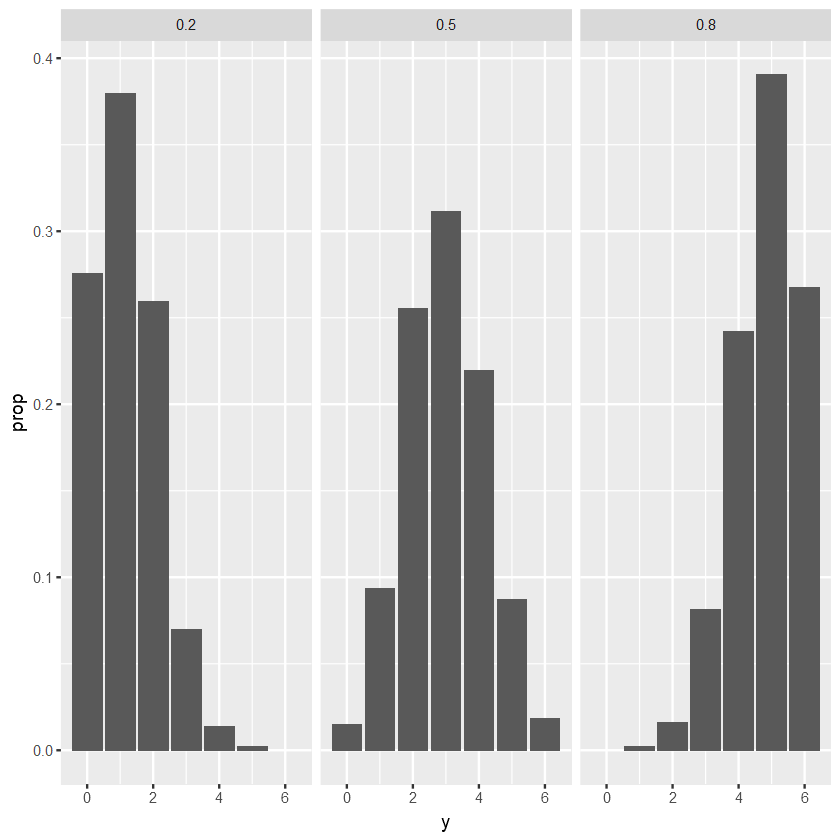

In [51]:
ggplot(chess_sim, aes(x = y)) + 
  stat_count(aes(y = ..prop..)) + 
  facet_wrap(~ pi)

- 승리횟수 $Y=1$일 때, $\pi$별 사후확률

In [52]:
win_one <- chess_sim %>% 
  filter(y == 1)

In [53]:
win_one %>% 
  tabyl(pi) %>% 
  adorn_totals("row")

,pi,n,percent
,<chr>,<int>,<dbl>
1,0.2,386,0.60883281
2,0.5,235,0.37066246
3,0.8,13,0.02050473
4,Total,634,1.00000000


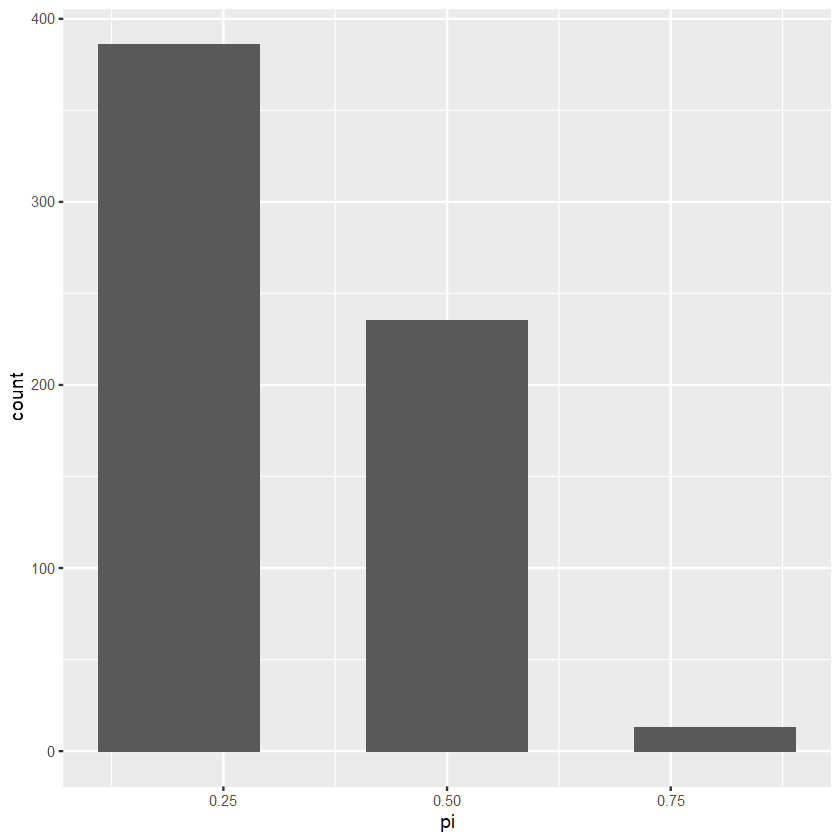

In [54]:
ggplot(win_one, aes(x = pi)) + 
  geom_bar()